[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/data-raw/blob/main/notebooks/preprocess_raw_signal.ipynb)

# Combinación de todas las bases de datos

El siguiente notebook explora de manera sencilla un archivo de matlab donde se guarda la información de un sensor.

In [46]:
try:
    import scipy.io
except ImportError:
    !pip install scipy

## 1. Librerias y configuraciones previas

In [47]:
import sys
import os
import zipfile

# Get the absolute path of the current notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    if not(os.path.exists("/content/data-raw/notebooks")):
        !git clone https://github.com/repos-especializacion-UdeA/data-raw.git
    %cd /content/data-raw/notebooks   
    %pwd
    ruta_base = '/content/data-raw/notebooks/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [48]:
# command to view figures in Jupyter notebook
# %matplotlib inline 

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import scipy as sc

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


## 2. Funciones

In [49]:
# Funciones externas
# ==============================================================================

def indice_postura(estimulo_data, num):
  # Cuando se lee un dataframe
  if isinstance(estimulo_data, pd.DataFrame):
    if num == 1:
      return (0,estimulo_data.index[estimulo_data == num][-1])
    else:
      index_cambios_anterior = (estimulo_data.index[estimulo_data == num - 1][0],estimulo_data.index[estimulo_data == num][-1])
      return (index_cambios_anterior[1],estimulo_data.index[estimulo_data == num][-1])
  else:
    # Cuando se lee un np array
    index_cambios = np.where(estimulo_data == num)[0]
    if num == 1:      
      return (0,index_cambios[-1])
    else:
      index_cambios_anterior = np.where(estimulo_data == num - 1)[0]
      return (index_cambios_anterior[-1] + 1,index_cambios[-1])


## 3. Carga del dataset

Inicialmente se verifica que el archivo csv este disponible.

In [50]:
# Verificando que se encuentre el archivo

DATASETS_PATH = "./datasets/"
dataset_zip = "raw_dataset.zip"
dataset_csv = "raw_dataset.csv"

if os.path.exists(DATASETS_PATH + dataset_zip):
    # Descoprimir dataset
    with zipfile.ZipFile(DATASETS_PATH + dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(".")
else:
    print("El dataset no existe - Ejecute el notebook \"merge_databases.ipynb\" antes de seguir")
    

A continuación se realiza la carga del dataset completo

In [51]:
# Carga del dataset
df = pd.read_csv(DATASETS_PATH + dataset_csv)

A continuación se verifica la carga del dataset:

In [52]:
# Mostrar las primeras filas del DataFrame
df.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.0684,0.0024,0.0024,0.0024,0.0024,0.0098,0.0024,0.0488,0.0024,0.0342,0,0
1,1,0.0586,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0415,0.0024,0.0293,0,0
2,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0391,0.0024,0.0244,0,0
3,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0342,0.0024,0.0171,0,0
4,1,0.0488,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0366,0.0024,0.0146,0,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 13 columns):
 #   Column  Dtype  
---  ------  -----  
 0   s       int64  
 1   emg_1   float64
 2   emg_2   float64
 3   emg_3   float64
 4   emg_4   float64
 5   emg_5   float64
 6   emg_6   float64
 7   emg_7   float64
 8   emg_8   float64
 9   emg_9   float64
 10  emg_10  float64
 11  rep     int64  
 12  label   int64  
dtypes: float64(10), int64(3)
memory usage: 270.9 MB


Hay un total de 13 columnas y ninguna tiene registros faltantes (missing values). Debido a esto, no nos tendremos que preocupar por realizar una imputación de datos.

Es importante aclarar que las columnas `s` (sujeto), `rep` (repeticion) y `label` (postura) estan relacionadas con datos categoricos por lo que vamos a proceder a realizar la transformación de estos.

In [54]:
# Convertir a categorico
df['s'] = pd.Categorical(df['s'])
df['rep'] = pd.Categorical(df['rep'])
df['label'] = pd.Categorical(df['label'])

Se verifica que los cambios en el dataframe se hayan efectuado.

In [55]:
#Lista de variables categóricas
catCols = df.select_dtypes(include = ['object', 'category']).columns.tolist()
print(f"Variables categoricas: {catCols}")
numCols = df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
print(f"Variables categoricas: {numCols}")

Variables categoricas: ['s', 'rep', 'label']
Variables categoricas: ['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


## Contextualización de los datos

Antes de seguir, como los datos a trabajar son señales se va a proceder a realizar unas graficas temporales de la señal para poner en contexto al lector. 

Es importante tener en cuenta que la frecuencia de muestro de la señal es de 100 Hz

In [56]:
sample_freq = 100

Vamos a agregar una columna asociada al tiempo en segundos en la que se hace la muestra:

In [57]:
# Columna del tiempo
df['t'] = (1/sample_freq)*df.index

In [58]:
df.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label,t
0,1,0.0684,0.0024,0.0024,0.0024,0.0024,0.0098,0.0024,0.0488,0.0024,0.0342,0,0,0.00
1,1,0.0586,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0415,0.0024,0.0293,0,0,0.01
2,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0391,0.0024,0.0244,0,0,0.02
3,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0342,0.0024,0.0171,0,0,0.03
4,1,0.0488,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0366,0.0024,0.0146,0,0,0.04


Tomemos las muestras asociadas al sujeto 1:

In [59]:
df_s1 = df[df['s'] == 1]

Graficando la señales asociadas a los sensores sEMG

In [60]:
emg_signals_s1 = df_s1.iloc[:,1:11].values
timeEMG_s1 = df_s1['t']
repeticiones_s1 = df_s1['rep']
posturas_s1 = df_s1['label']

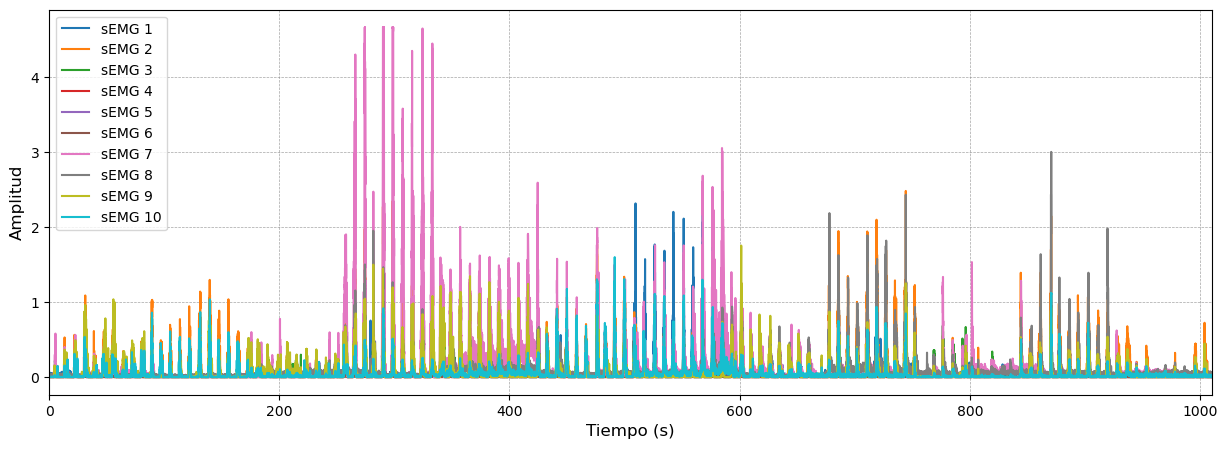

In [61]:
# Crear la figura y subgráficos
fig, ax = plt.subplots(figsize=(15, 5))
# print(emg_signals_s1)

for i in range(emg_signals_s1.shape[1]):
    ax.plot(timeEMG_s1, emg_signals_s1[:,i], label='sEMG ' + str(i+1))

# Agregar etiquetas de los ejes y título del gráfico
ax.set_xlabel('Tiempo (s)', fontsize=12)
ax.set_ylabel('Amplitud', fontsize=12)
# Configurar la cuadrícula con estilo personalizado
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Mostrar la leyenda para identificar cada serie de datos
ax.legend(loc='upper right')

# Mostrar la leyenda de líneas adicionales
ax.legend()

# Agregar una cuadrícula
ax.grid(True)

# Mostrar el gráfico
plt.xlim(min(timeEMG_s1),max(timeEMG_s1))
plt.show()

La siguiente grafica muestra no solo las señales emg sino tambien las repeticiones y las posturas para dar mas contexto:

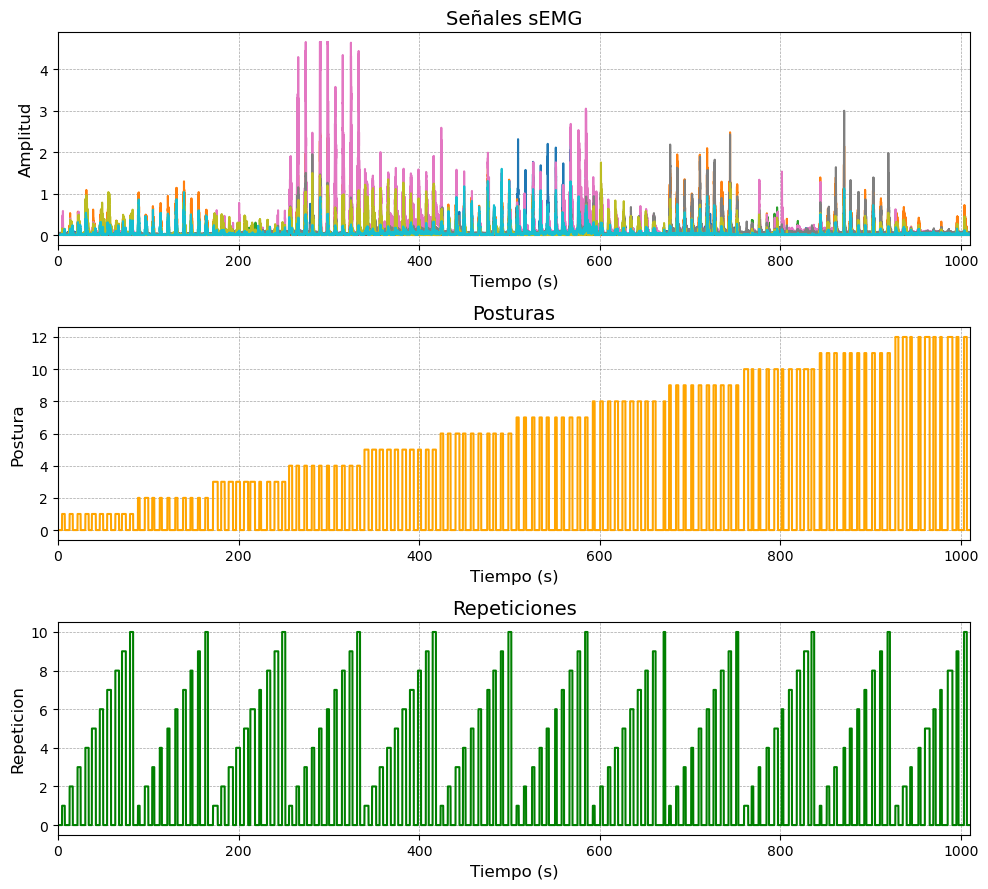

In [62]:
# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(3, 1, figsize=(10, 9))

# Gráfico 1: Seno
for i in range(emg_signals_s1.shape[1]):
    axs[0].plot(timeEMG_s1, emg_signals_s1[:,i])
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[0].set_xlim(min(timeEMG_s1),max(timeEMG_s1))


# Gráfico 2: Postura
axs[1].plot(timeEMG_s1, posturas_s1, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[1].set_xlim(min(timeEMG_s1),max(timeEMG_s1))

# Gráfico 3: Repeticion
axs[2].plot(timeEMG_s1, repeticiones_s1, color='green')
axs[2].set_title('Repeticiones', fontsize=14)
axs[2].set_xlabel('Tiempo (s)', fontsize=12)
axs[2].set_ylabel('Repeticion', fontsize=12)
axs[2].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axs[2].set_xlim(min(timeEMG_s1),max(timeEMG_s1))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots
plt.show()

Es importante notar, que la captura mostrada tiene todos los ejercicios y todas las repeticiones. En la siguiente figura se muestra la grafica resaltando el caso en el cual se lleva solamente los ejercicios asociados a la repetición 2.

In [63]:
# Numero del estimulo
def indice_postura(estimulo_data, num):
  if isinstance(estimulo_data, pd.DataFrame):
    # Nota: Cuadrar aca...
    return (estimulo_data.index[estimulo_data == num][0],estimulo_data.index[estimulo_data == num][-1])
  else:
    index_cambios = np.where(estimulo_data == num)[0]
    if num == 1:      
      return (0,index_cambios[-1])
    else:
      index_cambios_anterior = np.where(estimulo_data == num - 1)[0]
      return (index_cambios_anterior[-1] + 1,index_cambios[-1])

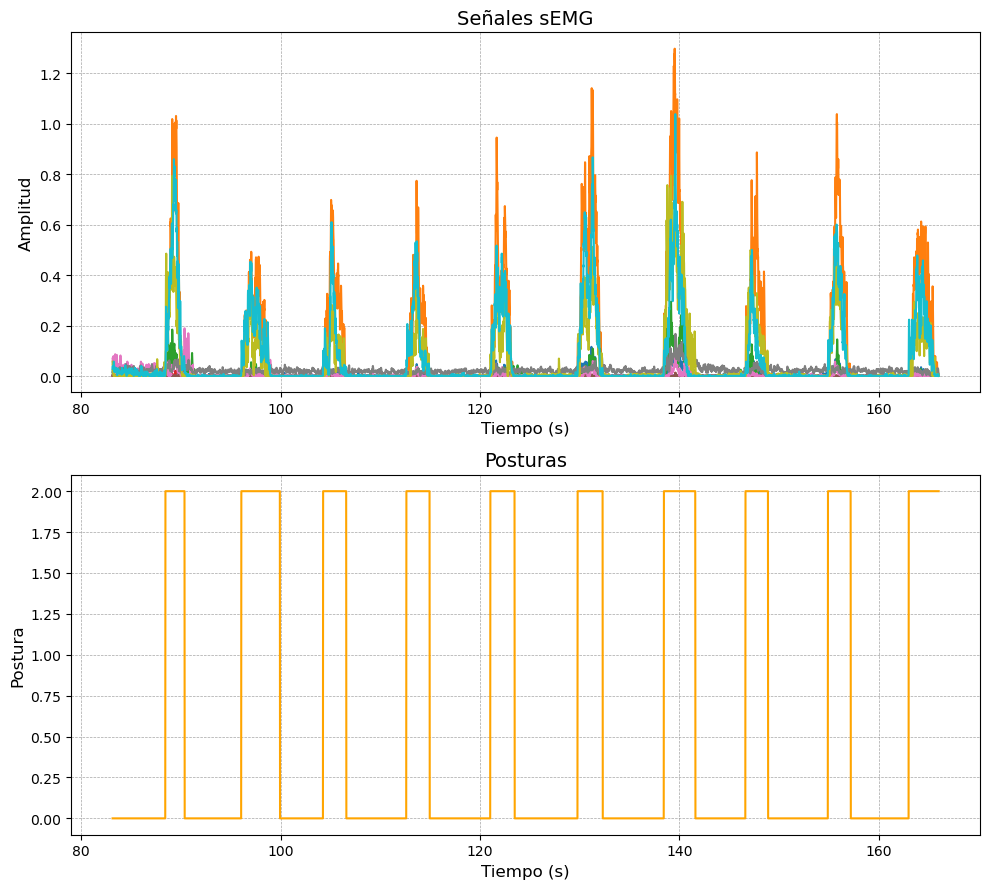

In [64]:
# Crear la figura y subgráficos
ind_post2 = indice_postura(posturas_s1,2)
start_index_post2 = ind_post2[0]
end_index_post2 = ind_post2[1]

timeEMG_post2 = timeEMG_s1[start_index_post2:end_index_post2 + 1] 
emgs_s1_post2 = emg_signals_s1[start_index_post2:end_index_post2 + 1,:]
label_s1_post2 = posturas_s1[start_index_post2:end_index_post2 + 1]

# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 1, figsize=(10, 9))

# Gráfico 1: Seno
for i in range(emgs_s1_post2.shape[1]):
    axs[0].plot(timeEMG_post2, emgs_s1_post2[:,i], label='sEMG ' + str(i+1))
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.xlim(min(timeEMG_post1),max(timeEMG_post1))


# Gráfico 2: Postura
axs[1].plot(timeEMG_post2, label_s1_post2, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.xlim(min(timeEMG_post1),max(timeEMG_post1))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots

plt.show()

## Filtrado

En la figura anterior se pueden apreciar las 10 repeticiones realizadas para la postura 2. Es importante notar que la señal esta muy ruidosa por lo que es necesario realizar un Filtrado.

In [65]:
# perform 2-order 1Hz low-pass filter
cutoff_freq = 1
nyquist = sample_freq/2
filter_order = 2
filter_type = 'lowpass'
normal_cutoff = cutoff_freq / nyquist
b, a = signal.butter(N = filter_order, 
                     Wn = normal_cutoff, 
                     btype = filter_type)

In [66]:
emgs_s1_post2_filter = signal.filtfilt(b, a, emgs_s1_post2, axis=0)

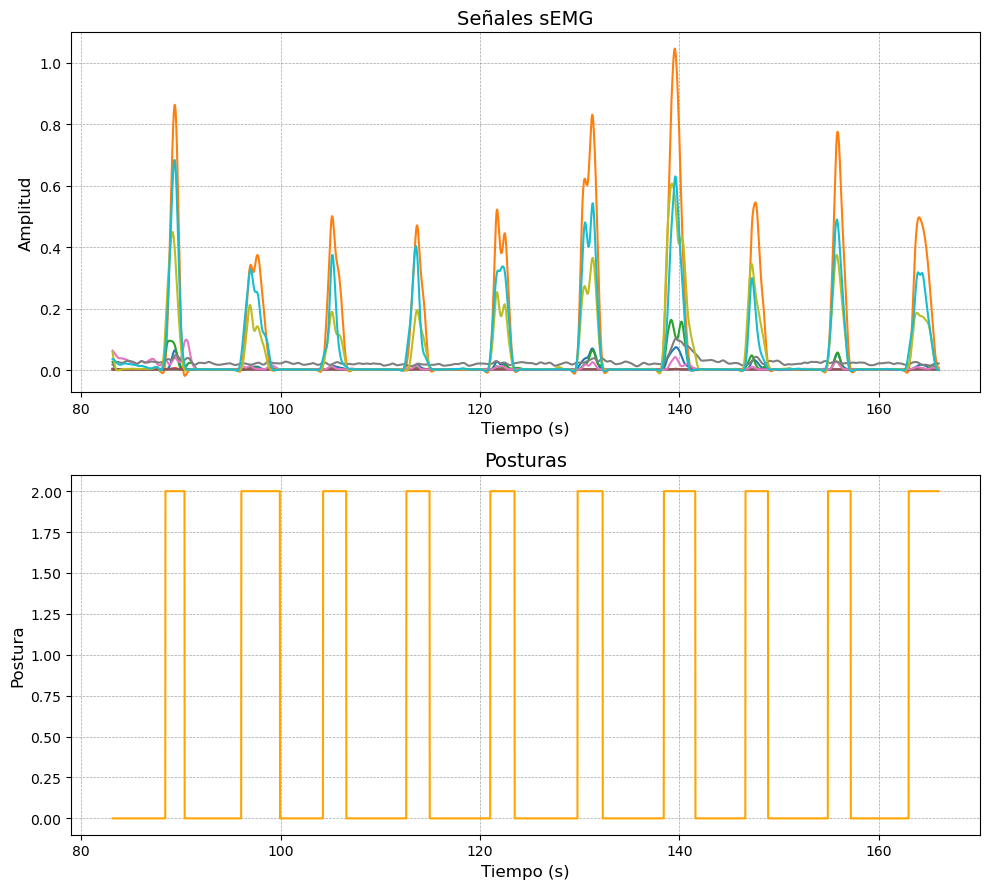

In [67]:
# Crear la figura y subgráficos

# Crear la figura y la cuadrícula de subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 1, figsize=(10, 9))

# Gráfico 1: sEMG
for i in range(emgs_s1_post2_filter.shape[1]):
    axs[0].plot(timeEMG_post2, emgs_s1_post2_filter[:,i], label='sEMG ' + str(i+1))
axs[0].set_title('Señales sEMG', fontsize=14)
axs[0].set_xlabel('Tiempo (s)', fontsize=12)
axs[0].set_ylabel('Amplitud', fontsize=12)
axs[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# plt.xlim(min(timeEMG_post2),max(timeEMG_post2))


# Gráfico 2: Postura
axs[1].plot(timeEMG_post2, label_s1_post2, color='orange')
axs[1].set_title('Posturas', fontsize=14)
axs[1].set_xlabel('Tiempo (s)', fontsize=12)
axs[1].set_ylabel('Postura', fontsize=12)
axs[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# plt.xlim(min(timeEMG_post2),max(timeEMG_post2))

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico con subplots

plt.show()

Teniendo en cuenta lo anterior, es necesario aplicarle todo el filtrado a los datos completos. A continuación se muestran las primeras filas del dataframe sin filtrar:

In [68]:
df.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label,t
0,1,0.0684,0.0024,0.0024,0.0024,0.0024,0.0098,0.0024,0.0488,0.0024,0.0342,0,0,0.00
1,1,0.0586,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0415,0.0024,0.0293,0,0,0.01
2,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0391,0.0024,0.0244,0,0,0.02
3,1,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0342,0.0024,0.0171,0,0,0.03
4,1,0.0488,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0366,0.0024,0.0146,0,0,0.04


Ahora se procede a filtrar cada una de las columnas de los valores de los sensores sEMG.

In [69]:
# Aplicando el filtrado en cada columna se tiene
for col in numCols:
    df[col] = signal.filtfilt(b, a, df[col], axis=0)

Los resultados del dataframe filtrado se muestra a continuación:

In [70]:
df.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label,t
0,1,0.067523,0.002402,0.002399,0.002403,0.002395,0.009800,0.0024,0.050357,0.0024,0.034192,0,0,0.00
1,1,0.066284,0.002402,0.002402,0.002404,0.002395,0.009474,0.0024,0.049707,0.0024,0.032820,0,0,0.01
2,1,0.065045,0.002403,0.002405,0.002404,0.002395,0.009149,0.0024,0.049050,0.0024,0.031452,0,0,0.02
3,1,0.063810,0.002403,0.002409,0.002405,0.002395,0.008827,0.0024,0.048390,0.0024,0.030091,0,0,0.03
4,1,0.062581,0.002404,0.002412,0.002406,0.002395,0.008507,0.0024,0.047726,0.0024,0.028743,0,0,0.04


## Exploración basica del dataset

Inicialmente se explorara el dataset para ver como luce:



In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 14 columns):
 #   Column  Dtype   
---  ------  -----   
 0   s       category
 1   emg_1   float64 
 2   emg_2   float64 
 3   emg_3   float64 
 4   emg_4   float64 
 5   emg_5   float64 
 6   emg_6   float64 
 7   emg_7   float64 
 8   emg_8   float64 
 9   emg_9   float64 
 10  emg_10  float64 
 11  rep     category
 12  label   category
 13  t       float64 
dtypes: category(3), float64(11)
memory usage: 237.0 MB


In [72]:
# Sujetos
df['s'].value_counts().sort_index()

s
1     101014
2     100686
3     100720
4     100835
5     100894
6     101083
7     100817
8     100854
9     100925
10    100778
11    100899
12    100920
13    100948
14    100785
15    101508
16    101191
17    101675
18    101323
19    101299
20    101565
21    101732
22    101884
23    101221
24    101698
25    101549
26    101642
27    100948
Name: count, dtype: int64

Vemos que el numero de muestras por sujeto es aproximadamente el mismo como se puede corroborar en el siguiente grafico de barras

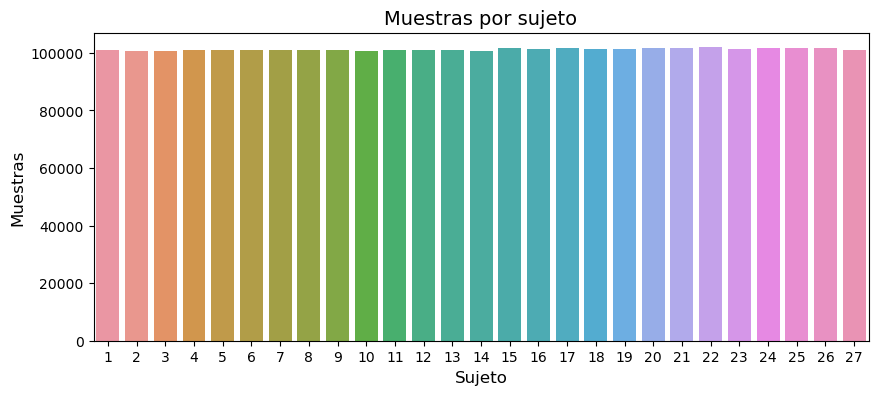

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='s', data=df)
ax.set_title('Muestras por sujeto', fontsize=14)
ax.set_xlabel('Sujeto', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

En lo que respecta a la cantidad de repeticiones tenemos:

In [74]:
df['rep'].value_counts().sort_index()

rep
0     1542153
1      122717
2      121490
3      120834
4      117230
5      118336
6      119118
7      116940
8      117748
9      117007
10     117820
Name: count, dtype: int64

Hay un total de 10 repeticiones (1 - 10); sin embargo, cuando el sujeto tiene la postura en la posición de descanso, el numero asociado a esta es 0. 

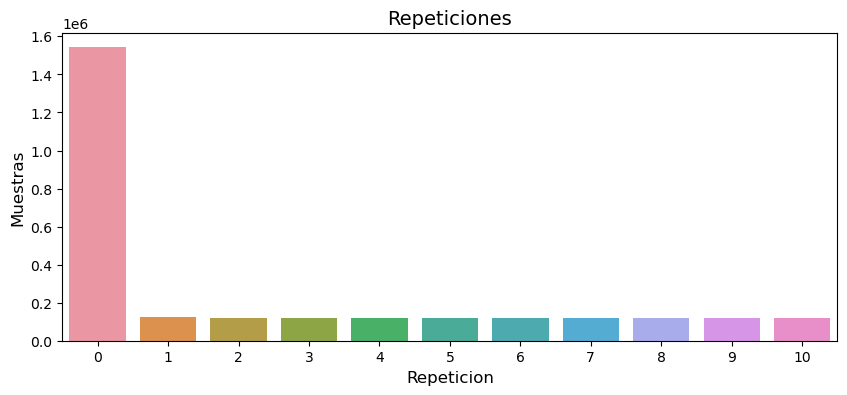

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='rep', data=df)
ax.set_title('Repeticiones', fontsize=14)
ax.set_xlabel('Repeticion', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

Tal y como se muestra en la grafica anterior, la cantidad de muestras en la posición de descanso es dominante respecto a las muestras asociadas a las repeticiones.

Ahora veamos la cantidad de muestras asociadas a una postura, siendo 0 la postura asociada a la posición de descanso:

In [76]:
df['label'].value_counts().sort_index()

label
0     1542153
1      102805
2      101570
3      113696
4       95109
5       95228
6       99451
7      100561
8      104325
9       95952
10      92413
11      88784
12      99346
Name: count, dtype: int64

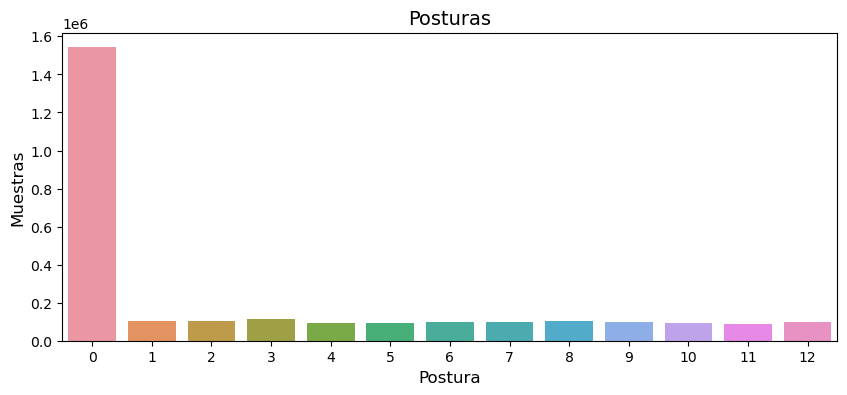

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x='label', data=df)
ax.set_title('Posturas', fontsize=14)
ax.set_xlabel('Postura', fontsize=12)
ax.set_ylabel('Muestras', fontsize=12)
plt.show()

Vemos que la mayor cantidad de muestras se da para la pocisión de descanso (0) por lo cual esta es una postura dominante

### Basic information about the dataset and data types

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 14 columns):
 #   Column  Dtype   
---  ------  -----   
 0   s       category
 1   emg_1   float64 
 2   emg_2   float64 
 3   emg_3   float64 
 4   emg_4   float64 
 5   emg_5   float64 
 6   emg_6   float64 
 7   emg_7   float64 
 8   emg_8   float64 
 9   emg_9   float64 
 10  emg_10  float64 
 11  rep     category
 12  label   category
 13  t       float64 
dtypes: category(3), float64(11)
memory usage: 237.0 MB


In [79]:
# Convertir a categorico
df['s'] = pd.Categorical(df['s'])
df['rep'] = pd.Categorical(df['rep'])
df['label'] = pd.Categorical(df['label'])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731393 entries, 0 to 2731392
Data columns (total 14 columns):
 #   Column  Dtype   
---  ------  -----   
 0   s       category
 1   emg_1   float64 
 2   emg_2   float64 
 3   emg_3   float64 
 4   emg_4   float64 
 5   emg_5   float64 
 6   emg_6   float64 
 7   emg_7   float64 
 8   emg_8   float64 
 9   emg_9   float64 
 10  emg_10  float64 
 11  rep     category
 12  label   category
 13  t       float64 
dtypes: category(3), float64(11)
memory usage: 237.0 MB


In [81]:
df.columns

Index(['s', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7',
       'emg_8', 'emg_9', 'emg_10', 'rep', 'label', 't'],
      dtype='object')

In [82]:
# Completitud
df.isna().sum()

s         0
emg_1     0
emg_2     0
emg_3     0
emg_4     0
emg_5     0
emg_6     0
emg_7     0
emg_8     0
emg_9     0
emg_10    0
rep       0
label     0
t         0
dtype: int64

In [83]:
display(df.nunique())
display(df['s'].unique())
display(df['rep'].unique())
display(df['label'].unique())

s              27
emg_1     2731393
emg_2     2731189
emg_3     2731393
emg_4     2729274
emg_5     2731393
emg_6     2717121
emg_7     2731393
emg_8     2731393
emg_9     2728796
emg_10    2731393
rep            11
label          13
t         2731393
dtype: int64

[1, 2, 3, 4, 5, ..., 23, 24, 25, 26, 27]
Length: 27
Categories (27, int64): [1, 2, 3, 4, ..., 24, 25, 26, 27]

[0, 1, 2, 3, 4, ..., 6, 7, 8, 9, 10]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

[0, 1, 2, 3, 4, ..., 8, 9, 10, 11, 12]
Length: 13
Categories (13, int64): [0, 1, 2, 3, ..., 9, 10, 11, 12]

### Analisis univariado

In [84]:
# Display in normal notation instead of scientific
with pd.option_context('float_format', '{:f}'.format):
    display(df.iloc[:,:-2].describe())


,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
count,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000,2731393.000000
mean,0.195195,0.122251,0.122080,0.042121,0.011902,0.034457,0.303733,0.303680,0.117703,0.234548
std,0.320324,0.220754,0.302355,0.120017,0.031780,0.089595,0.522617,0.366763,0.288361,0.341319
min,-0.050024,-0.048130,-0.115533,-0.043199,-0.010148,-0.020428,-0.124056,-0.036300,-0.126998,-0.059506
25%,0.004995,0.002435,0.002538,0.002400,0.002455,0.002403,0.023524,0.076280,0.002404,0.016688
50%,0.057786,0.016516,0.008818,0.002550,0.002578,0.003350,0.130650,0.198724,0.006833,0.118852
75%,0.260736,0.148558,0.118000,0.022031,0.004293,0.022775,0.360370,0.386994,0.099222,0.306058
max,4.772827,2.992637,4.799877,4.715544,0.869776,1.902337,4.832991,4.480645,4.826315,4.322086


In [85]:
df.columns[1:11]

Index(['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8',
       'emg_9', 'emg_10'],
      dtype='object')

Para obtener la correlacion vamos a volver el label numerico (de nuevo)

In [86]:
df['label'] = df['label'].astype('uint8')
# Calculate the correlation matrix
correlation_matrix = df[['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8','emg_9', 'emg_10','label']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
emg_1,1.000000,0.453761,0.326322,0.280480,0.382454,0.176835,0.191175,0.340444,0.311100,0.293134,0.297431
emg_2,0.453761,1.000000,0.451567,0.381319,0.548464,0.419069,0.480181,0.418293,0.496885,0.457090,0.285061
emg_3,0.326322,0.451567,1.000000,0.510592,0.453392,0.206657,0.307099,0.377289,0.601478,0.405319,0.279396
emg_4,0.280480,0.381319,0.510592,1.000000,0.670789,0.249064,0.280444,0.381770,0.482089,0.410729,0.269300
emg_5,0.382454,0.548464,0.453392,0.670789,1.000000,0.641675,0.609626,0.477803,0.476647,0.501956,0.220875
emg_6,0.176835,0.419069,0.206657,0.249064,0.641675,1.000000,0.681425,0.334104,0.293283,0.450019,0.165580
emg_7,0.191175,0.480181,0.307099,0.280444,0.609626,0.681425,1.000000,0.446624,0.372298,0.571753,0.166338
emg_8,0.340444,0.418293,0.377289,0.381770,0.477803,0.334104,0.446624,1.000000,0.318840,0.537299,0.346617
emg_9,0.311100,0.496885,0.601478,0.482089,0.476647,0.293283,0.372298,0.318840,1.000000,0.388849,0.265918
emg_10,0.293134,0.457090,0.405319,0.410729,0.501956,0.450019,0.571753,0.537299,0.388849,1.000000,0.287247


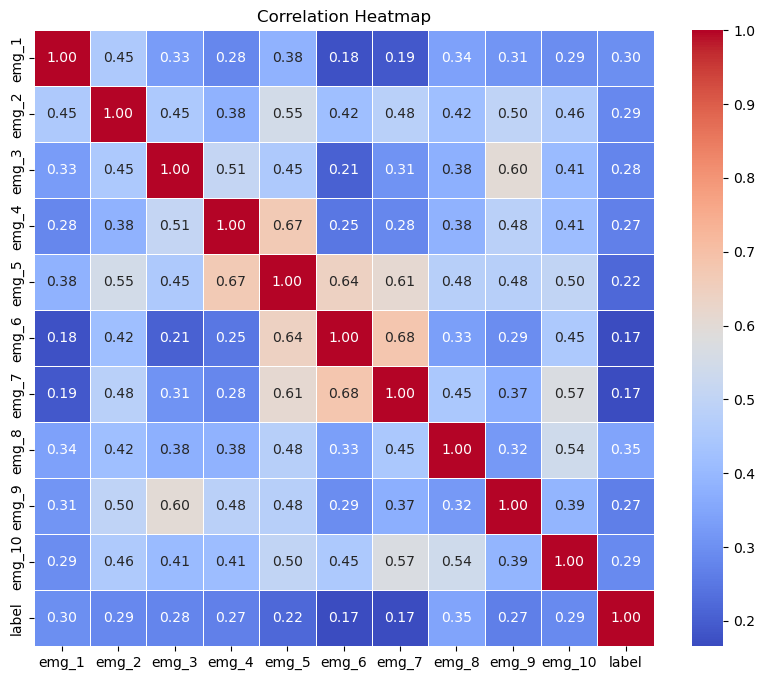

In [87]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Eliminemos cosas que no se necesitan

In [88]:
df_filtered = df.drop(['t'], axis=1)
df_filtered.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.067523,0.002402,0.002399,0.002403,0.002395,0.009800,0.0024,0.050357,0.0024,0.034192,0,0
1,1,0.066284,0.002402,0.002402,0.002404,0.002395,0.009474,0.0024,0.049707,0.0024,0.032820,0,0
2,1,0.065045,0.002403,0.002405,0.002404,0.002395,0.009149,0.0024,0.049050,0.0024,0.031452,0,0
3,1,0.063810,0.002403,0.002409,0.002405,0.002395,0.008827,0.0024,0.048390,0.0024,0.030091,0,0
4,1,0.062581,0.002404,0.002412,0.002406,0.002395,0.008507,0.0024,0.047726,0.0024,0.028743,0,0


### Guardado del archivo

In [89]:
filter_dataset_name = "filter_dataset"
filter_dataset_csv = filter_dataset_name + ".csv"
dest_zip = filter_dataset_name + ".zip"
dest_dir_datasets = "./datasets/"
if not(os.path.exists(dest_dir_datasets + dest_zip)):
    # Archivo no existe
    # Se exporta el dataframe a un archivo CSV
    print(f"Generando archivo {filter_dataset_csv}")
    df_filtered.to_csv(dest_dir_datasets + filter_dataset_csv, index=False)
    stat_dataset = os.stat(dest_dir_datasets + filter_dataset_csv)
    print(f"Tamaño del dataset {filter_dataset_csv}: {stat_dataset.st_size/((1024 * 1024))} MB")
    # Creacion del archivo comprimido
    with zipfile.ZipFile(dest_dir_datasets + dest_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        print(f"Archivo {dest_zip} generado")
        zipf.write(dest_dir_datasets + filter_dataset_csv)
        os.remove(dest_dir_datasets + filter_dataset_csv)
        print(f"Archivo {filter_dataset_csv} eliminado")
        os.remove(dest_dir_datasets + dataset_csv)
        print(f"Archivo {dataset_csv} eliminado")        
else:
   print("No se hace nada el archivo ya existe")

Generando archivo filter_dataset.csv
Tamaño del dataset filter_dataset.csv: 555.1070766448975 MB
Archivo filter_dataset.zip generado
Archivo filter_dataset.csv eliminado
Archivo raw_dataset.csv eliminado


Hasta aqui queda la base de datos estructurada. La siguiente parte consiste en meterla al modelo y rezar para que de.

Aqui no se van a eliminar outlines para evitar la perdida de continuidad de la señal.

## Referencias

* https://github.com/chuawt/eda-starter
* https://www.kaggle.com/code/bextuychiev/my-6-part-powerful-eda-template
* https://community.ibm.com/community/user/ai-datascience/blogs/shivam-solanki1/2020/02/19/eda-exploratory-data-analysis-with-example-in-jupy
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks
* https://www.datacamp.com/es/tutorial/pandas-profiling-ydata-profiling-in-python-guide
* https://docs.profiling.ydata.ai/latest/
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Statistics_for_ML.ipynb
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Online_Ed_Adaptability.ipynb
* https://github.com/Saba-Gul/Exploratory-Data-Analysis-and-Statistical-Analysis-Notebooks/blob/main/Heart_Failure_Survival_Classification.ipynb
* https://github.com/akueisara/audio-signal-processing/blob/master/week%204/A4/A4Part2.py
* https://docs.profiling.ydata.ai/latest/